# Classifier using LSTM layers

## 1. Importing Libraries

In [13]:
import torch

import numpy as np

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Data Preprocessing

### 2.1. Loading the data

In [14]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/ctrlpts/calculator_ctrlpt.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [15]:
calculator_data.get('train').shape, camera_data.get('train').shape, cellphone_data.get('train').shape

((17928,), (17938,), (17976,))

In [16]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
calculator_sliced = slice_data(calculator_data)[:5000]
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(calculator_sliced, camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000,), (12000,), (3000,), (3000,))

In [18]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print(len(train_loader))
print(len(test_loader))

188
47


In [20]:
X_train_standardized.shape, X_test_standardized.shape

((12000, 29, 3), (3000, 29, 3))

## 3. Model Building

### 3.1. Fully classical Neural Network

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class HybridNN(nn.Module):
    def __init__(self, num_categories, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Dense layer for classification
        self.fc4 = nn.Linear(14, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [22]:
checkpoint_filepath = 'models/2edition_lstm/best_model_weights_3classes_ctrlpts.pth'

In [23]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(50):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 188/188 [00:00<00:00, 270.88it/s]


Epoch 1, Accuracy: 0.509, Loss: 1.021171753393843, Validation Accuracy: 0.5883333333333334, Validation Loss: 0.8553295135498047


100%|██████████| 188/188 [00:00<00:00, 283.69it/s]


Epoch 2, Accuracy: 0.65725, Loss: 0.7567823621186804, Validation Accuracy: 0.697, Validation Loss: 0.7022719383239746


100%|██████████| 188/188 [00:00<00:00, 284.80it/s]


Epoch 3, Accuracy: 0.7225833333333334, Loss: 0.6461143996170227, Validation Accuracy: 0.7066666666666667, Validation Loss: 0.6677065491676331


100%|██████████| 188/188 [00:00<00:00, 288.77it/s]


Epoch 4, Accuracy: 0.7500833333333333, Loss: 0.5901624793384938, Validation Accuracy: 0.724, Validation Loss: 0.6453723907470703


100%|██████████| 188/188 [00:00<00:00, 289.39it/s]


Epoch 5, Accuracy: 0.7744166666666666, Loss: 0.5436669659424336, Validation Accuracy: 0.733, Validation Loss: 0.632135272026062


100%|██████████| 188/188 [00:00<00:00, 290.66it/s]


Epoch 6, Accuracy: 0.7871666666666667, Loss: 0.5098471468750466, Validation Accuracy: 0.7366666666666667, Validation Loss: 0.621832013130188


100%|██████████| 188/188 [00:00<00:00, 272.32it/s]


Epoch 7, Accuracy: 0.7976666666666666, Loss: 0.4889293409725453, Validation Accuracy: 0.743, Validation Loss: 0.6062427163124084


100%|██████████| 188/188 [00:00<00:00, 282.34it/s]


Epoch 8, Accuracy: 0.8035, Loss: 0.4712095005398101, Validation Accuracy: 0.7356666666666667, Validation Loss: 0.6257288455963135


100%|██████████| 188/188 [00:00<00:00, 284.23it/s]


Epoch 9, Accuracy: 0.8156666666666667, Loss: 0.4518438710018675, Validation Accuracy: 0.7473333333333333, Validation Loss: 0.6134302616119385


100%|██████████| 188/188 [00:00<00:00, 284.18it/s]


Epoch 10, Accuracy: 0.82075, Loss: 0.4355600875742892, Validation Accuracy: 0.75, Validation Loss: 0.6089268326759338


100%|██████████| 188/188 [00:00<00:00, 283.89it/s]


Epoch 11, Accuracy: 0.8280833333333333, Loss: 0.417671734586041, Validation Accuracy: 0.7453333333333333, Validation Loss: 0.609885036945343


100%|██████████| 188/188 [00:00<00:00, 289.51it/s]


Epoch 12, Accuracy: 0.8361666666666666, Loss: 0.4050563302762965, Validation Accuracy: 0.755, Validation Loss: 0.6212538480758667


100%|██████████| 188/188 [00:00<00:00, 292.63it/s]


Epoch 13, Accuracy: 0.843, Loss: 0.3922582721298045, Validation Accuracy: 0.7536666666666667, Validation Loss: 0.6171563267707825


100%|██████████| 188/188 [00:00<00:00, 282.26it/s]


Epoch 14, Accuracy: 0.8485, Loss: 0.37968842732779523, Validation Accuracy: 0.7573333333333333, Validation Loss: 0.6262789964675903


100%|██████████| 188/188 [00:00<00:00, 285.48it/s]


Epoch 15, Accuracy: 0.85325, Loss: 0.36311296421162625, Validation Accuracy: 0.7533333333333333, Validation Loss: 0.6484327912330627


100%|██████████| 188/188 [00:00<00:00, 292.25it/s]


Epoch 16, Accuracy: 0.85425, Loss: 0.3627889434549403, Validation Accuracy: 0.7553333333333333, Validation Loss: 0.6355630159378052


100%|██████████| 188/188 [00:00<00:00, 280.94it/s]


Epoch 17, Accuracy: 0.8613333333333333, Loss: 0.345577358565432, Validation Accuracy: 0.7573333333333333, Validation Loss: 0.6531658172607422


100%|██████████| 188/188 [00:00<00:00, 265.68it/s]


Epoch 18, Accuracy: 0.8664166666666666, Loss: 0.34087172126833426, Validation Accuracy: 0.756, Validation Loss: 0.6486547589302063


100%|██████████| 188/188 [00:00<00:00, 260.45it/s]


Epoch 19, Accuracy: 0.8708333333333333, Loss: 0.33208978176116943, Validation Accuracy: 0.7613333333333333, Validation Loss: 0.6591655611991882


100%|██████████| 188/188 [00:00<00:00, 293.80it/s]


Epoch 20, Accuracy: 0.8740833333333333, Loss: 0.3259875622201473, Validation Accuracy: 0.7583333333333333, Validation Loss: 0.6624777317047119


100%|██████████| 188/188 [00:00<00:00, 275.14it/s]


Epoch 21, Accuracy: 0.87625, Loss: 0.31591631155064764, Validation Accuracy: 0.762, Validation Loss: 0.6672135591506958


100%|██████████| 188/188 [00:00<00:00, 293.92it/s]


Epoch 22, Accuracy: 0.8833333333333333, Loss: 0.30149848917697336, Validation Accuracy: 0.761, Validation Loss: 0.6806653141975403


100%|██████████| 188/188 [00:00<00:00, 276.93it/s]


Epoch 23, Accuracy: 0.8899166666666667, Loss: 0.29330245571884705, Validation Accuracy: 0.7596666666666667, Validation Loss: 0.6847867369651794


100%|██████████| 188/188 [00:00<00:00, 287.86it/s]


Epoch 24, Accuracy: 0.88325, Loss: 0.2987814173102379, Validation Accuracy: 0.7593333333333333, Validation Loss: 0.6803421378135681


100%|██████████| 188/188 [00:00<00:00, 287.08it/s]


Epoch 25, Accuracy: 0.8915, Loss: 0.28657521973264977, Validation Accuracy: 0.7533333333333333, Validation Loss: 0.7048802971839905


100%|██████████| 188/188 [00:00<00:00, 284.13it/s]


Epoch 26, Accuracy: 0.8965833333333333, Loss: 0.2702719502230274, Validation Accuracy: 0.7576666666666667, Validation Loss: 0.7030324339866638


100%|██████████| 188/188 [00:00<00:00, 261.85it/s]


Epoch 27, Accuracy: 0.89525, Loss: 0.27596994533025204, Validation Accuracy: 0.755, Validation Loss: 0.7335010170936584


100%|██████████| 188/188 [00:00<00:00, 293.34it/s]


Epoch 28, Accuracy: 0.8968333333333334, Loss: 0.26824699366029275, Validation Accuracy: 0.7553333333333333, Validation Loss: 0.6996426582336426


100%|██████████| 188/188 [00:00<00:00, 283.97it/s]


Epoch 29, Accuracy: 0.9015833333333333, Loss: 0.26400806810310545, Validation Accuracy: 0.7566666666666667, Validation Loss: 0.7272308468818665


100%|██████████| 188/188 [00:00<00:00, 281.06it/s]


Epoch 30, Accuracy: 0.9030833333333333, Loss: 0.2574961328522322, Validation Accuracy: 0.7446666666666667, Validation Loss: 0.7485868334770203


100%|██████████| 188/188 [00:00<00:00, 293.76it/s]


Epoch 31, Accuracy: 0.9056666666666666, Loss: 0.25482303768079334, Validation Accuracy: 0.749, Validation Loss: 0.7336233258247375


100%|██████████| 188/188 [00:00<00:00, 266.70it/s]


Epoch 32, Accuracy: 0.9111666666666667, Loss: 0.2467300615649908, Validation Accuracy: 0.754, Validation Loss: 0.7324475646018982


100%|██████████| 188/188 [00:00<00:00, 293.20it/s]


Epoch 33, Accuracy: 0.9150833333333334, Loss: 0.23490073286155436, Validation Accuracy: 0.759, Validation Loss: 0.7516118884086609


100%|██████████| 188/188 [00:00<00:00, 290.91it/s]


Epoch 34, Accuracy: 0.9141666666666667, Loss: 0.23801516523545094, Validation Accuracy: 0.7533333333333333, Validation Loss: 0.7650073766708374


100%|██████████| 188/188 [00:00<00:00, 290.87it/s]


Epoch 35, Accuracy: 0.9101666666666667, Loss: 0.24311958970700173, Validation Accuracy: 0.7613333333333333, Validation Loss: 0.7528509497642517


100%|██████████| 188/188 [00:00<00:00, 261.20it/s]


Epoch 36, Accuracy: 0.9149166666666667, Loss: 0.23332973375440913, Validation Accuracy: 0.7516666666666667, Validation Loss: 0.7687816619873047


100%|██████████| 188/188 [00:00<00:00, 261.95it/s]


Epoch 37, Accuracy: 0.9158333333333334, Loss: 0.22765730642416376, Validation Accuracy: 0.7556666666666667, Validation Loss: 0.780782163143158


100%|██████████| 188/188 [00:00<00:00, 285.24it/s]


Epoch 38, Accuracy: 0.9210833333333334, Loss: 0.21936120992486782, Validation Accuracy: 0.75, Validation Loss: 0.7956420183181763


100%|██████████| 188/188 [00:00<00:00, 263.70it/s]


Epoch 39, Accuracy: 0.9223333333333333, Loss: 0.2171925659430154, Validation Accuracy: 0.761, Validation Loss: 0.7827945947647095


100%|██████████| 188/188 [00:00<00:00, 260.83it/s]


Epoch 40, Accuracy: 0.92625, Loss: 0.2083926844866352, Validation Accuracy: 0.7523333333333333, Validation Loss: 0.795327365398407


100%|██████████| 188/188 [00:00<00:00, 269.11it/s]


Epoch 41, Accuracy: 0.9249166666666667, Loss: 0.20541388038149538, Validation Accuracy: 0.7526666666666667, Validation Loss: 0.8275938630104065


100%|██████████| 188/188 [00:00<00:00, 295.27it/s]


Epoch 42, Accuracy: 0.936, Loss: 0.19068391971844942, Validation Accuracy: 0.759, Validation Loss: 0.8279935121536255


100%|██████████| 188/188 [00:00<00:00, 265.62it/s]


Epoch 43, Accuracy: 0.9383333333333334, Loss: 0.1807227735704881, Validation Accuracy: 0.7526666666666667, Validation Loss: 0.8323197364807129


100%|██████████| 188/188 [00:00<00:00, 285.43it/s]


Epoch 44, Accuracy: 0.9343333333333333, Loss: 0.18807947708967518, Validation Accuracy: 0.7526666666666667, Validation Loss: 0.8494209051132202


100%|██████████| 188/188 [00:00<00:00, 296.82it/s]


Epoch 45, Accuracy: 0.93075, Loss: 0.19512957839810469, Validation Accuracy: 0.7546666666666667, Validation Loss: 0.8386834859848022


100%|██████████| 188/188 [00:00<00:00, 291.08it/s]


Epoch 46, Accuracy: 0.9386666666666666, Loss: 0.17600590349274112, Validation Accuracy: 0.7583333333333333, Validation Loss: 0.8500579595565796


100%|██████████| 188/188 [00:00<00:00, 275.31it/s]


Epoch 47, Accuracy: 0.939, Loss: 0.17184396678621464, Validation Accuracy: 0.7573333333333333, Validation Loss: 0.8844001889228821


100%|██████████| 188/188 [00:00<00:00, 284.85it/s]


Epoch 48, Accuracy: 0.9344166666666667, Loss: 0.18384123821445603, Validation Accuracy: 0.7636666666666667, Validation Loss: 0.8316130638122559


100%|██████████| 188/188 [00:00<00:00, 284.27it/s]


Epoch 49, Accuracy: 0.936, Loss: 0.18505937021542737, Validation Accuracy: 0.7593333333333333, Validation Loss: 0.8672501444816589


100%|██████████| 188/188 [00:00<00:00, 285.76it/s]


Epoch 50, Accuracy: 0.9400833333333334, Loss: 0.1761303891011692, Validation Accuracy: 0.7643333333333333, Validation Loss: 0.8470926880836487


## 5. Model Evaluation

### 5.1. Plotting the Training and Validation Loss

In [24]:
# Convert list of cuda tensors to numpy array of floats
val_loss_list = [acc.cpu().numpy() for acc in val_loss_list]

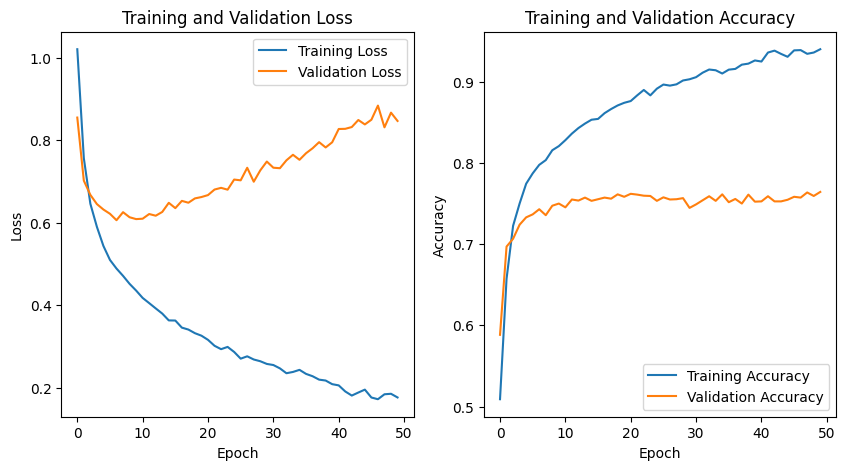

In [25]:
import matplotlib.pyplot as plt

#Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [27]:
model = HybridNN(num_categories=len(classes), fname=checkpoint_filepath)

In [28]:
outputs = model.predict(X_test)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
y_pred = np.argmax(outputs, axis=1)
y_pred

In [ ]:
INDEX = 6

out = model.predict([X_test[:2500][INDEX]])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])